# **Máquina de Vectores de Soporte (SVM)**

En este laboratorio, aprenderás y obtendrás prácticas prácticas sobre el modelo de Máquina de Vectores de Soporte (SVM).

Usaremos un conjunto de datos real sobre sugerencias de alimentos para diabéticos, que contiene información nutricional detallada sobre un artículo de comida. El objetivo es clasificar qué alimento debe elegir un paciente diabético con más frecuencia o con menos frecuencia para un alimento específico dado sus nutrientes.

## Objetivos

Después de completar este laboratorio, podrás:

* Entrenar y evaluar clasificadores SVM.
* Ajustar hiperparámetros importantes de SVM, como la regularización y los tipos de kernel.
* Trazar hiperplanos y márgenes a partir de modelos SVM entrenados.

## Descripción general de SVM

SVM intenta encontrar hiperplanos que tengan el margen máximo. Los hiperplanos están determinados por los vectores de soporte (puntos de datos que tienen la menor distancia a los hiperplanos). Mientras tanto, para reducir la varianza del modelo, el modelo SVM tiene como objetivo encontrar los márgenes máximos posibles para que los datos no vistos tengan más probabilidades de clasificarse correctamente.

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/module3_svm/images/svm.png" width="720" alt="evaluation metrics">
</center>

SVM aborda la separación no lineal a través del truco del kernel. Los kernels son un tipo especial de función que toma dos vectores y devuelve un número real, similar a una operación de producto punto. Como tal, los kernels no son funciones de mapeo reales desde espacios de baja dimensión a espacios de alta dimensión.

Por ejemplo, supongamos que tenemos dos vectores $x = (x_{1}, x_{2})$ and $y = (y_{1}, y_{2})$

Ahora tenemos un kernel polinomial simple como el siguiente:

$$k(x, y) = (x^Ty)^2$$

Si aplicamos el kernel en los vectores `x` y `y`, obtendremos:

$$k(x, y) = (x^Ty)^2 = (x_{1}y_{1} + x_{2}y_{2})^2 = x_{1}^2y_{1}^2 + x_{2}^2y_{2}^2 + 2x_{1}x_{2}y_{1}y_{2}$$

Se puede ver como un producto punto entre dos vectores de mayor dimensión (`3-dimensional`):

$$\hat{x} = (x_{1}^2, x_{2}^2, \sqrt{2}x_{1}x_{2}) $$

$$\hat{y} = (y_{1}^2, x_{2}^2, \sqrt{2}y_{1}y_{2})$$

Como tal, calcular el `k(x, y)` es equivalente a calcular un producto punto de los vectores de mayor dimensión, sin realizar las transformaciones del espacio de características. En consecuencia, el SVM con kernels no lineales puede transformar características existentes en características de alta dimensión que pueden ser linealmente separadas en espacios de mayor dimensión.

## Configurar el entorno del laboratorio

In [55]:
# Todas las bibliotecas necesarias para este laboratorio están listadas a continuación. Las bibliotecas preinstaladas en Skills Network Labs están comentadas.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0

# Instalar el paquete imbalanced-learn
# !pip install imbalanced-learn==0.8.0
# Nota: Si tu entorno no soporta "!mamba install", usa "!pip install"


In [56]:
# Importar los paquetes necesarios
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score,confusion_matrix, precision_recall_fscore_support, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler


In [57]:
# Configurar una semilla aleatoria como 123
rs = 123

## Cargar y explorar el conjunto de datos

Primero, carguemos el conjunto de datos como un `DataFrame` de `Pandas` y realicemos algunas exploraciones básicas.

In [58]:
# Cargamos el dataset
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/food_items_binary.csv"
food_df = pd.read_csv(dataset_url)

y echemos un vistazo rápido a las primeras 5 filas.

In [59]:
food_df.head(10)

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron,class
0,149.0,0,0.0,0.0,0.0,0.0,0,9.0,9.8,0.0,0.0,0,1.3,0,0,0,0,0
1,123.0,0,0.0,0.0,0.0,0.0,0,5.0,6.6,0.0,0.0,0,0.8,0,0,0,0,0
2,150.0,0,0.0,0.0,0.0,0.0,0,4.0,11.4,0.0,0.0,0,1.3,0,0,0,0,0
3,110.0,0,0.0,0.0,0.0,0.0,0,6.0,7.0,0.0,0.0,0,0.8,0,0,0,0,0
4,143.0,0,0.0,0.0,0.0,0.0,0,7.0,13.1,0.0,0.0,0,1.0,0,0,0,0,0
5,110.0,0,0.0,0.0,0.0,0.0,0,6.0,7.0,0.0,0.0,0,0.8,0,0,0,0,0
6,142.0,0,0.0,0.0,0.0,0.0,0,12.0,10.6,0.0,0.0,0,1.2,0,0,0,0,0
7,102.0,0,0.0,0.0,0.0,0.0,0,13.0,5.0,0.0,0.0,0,0.7,0,0,0,0,0
8,145.0,0,0.0,0.0,0.0,0.0,0,17.0,11.0,0.0,0.0,0,1.2,0,0,0,0,0
9,171.0,0,0.0,0.0,0.0,0.0,0,8.0,13.7,0.0,0.0,0,2.5,0,0,0,0,0


In [60]:
# Obtener las entradas de las filas con las columnas de 0 a -1 (16)

feature_cols = list(food_df.iloc[:, :-1].columns)
feature_cols

['Calories',
 'Total Fat',
 'Saturated Fat',
 'Monounsaturated Fat',
 'Polyunsaturated Fat',
 'Trans Fat',
 'Cholesterol',
 'Sodium',
 'Total Carbohydrate',
 'Dietary Fiber',
 'Sugars',
 'Sugar Alcohol',
 'Protein',
 'Vitamin A',
 'Vitamin C',
 'Calcium',
 'Iron']

In [61]:
X = food_df.iloc[:, :-1]
y = food_df.iloc[:, -1:]

In [62]:
X.describe()

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron
count,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000
mean,105.098835,2.318235,0.368920,0.309216,0.264116,0.007069,4.308679,235.053659,15.510719,1.806074,3.734756,0.059039,4.298975,6.636733,6.487237,3.937688,5.510014
std,77.224368,3.438941,0.737164,1.310260,2.848250,0.094783,14.788162,252.438163,14.028570,4.099947,5.013685,0.771173,5.349881,19.658111,19.566500,7.892694,9.855960
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,3.700000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,13.000000,1.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,2.000000
75%,140.000000,3.000000,0.500000,0.000000,0.000000,0.000000,0.000000,375.500000,24.000000,3.000000,5.000000,0.000000,6.000000,6.000000,4.000000,4.000000,8.000000
max,2210.000000,24.000000,8.000000,16.800000,235.000000,2.500000,450.000000,2220.000000,270.000000,305.000000,39.000000,19.000000,70.000000,370.000000,280.000000,110.000000,100.000000


Como podemos ver en los resultados anteriores, este conjunto de datos de alimentos contiene 17 tipos de nutrientes sobre un alimento, como Calorías, Grasa Total, Proteína, Azúcar, entre otros, como variables numéricas.

A continuación, vamos a revisar la variable objetivo, como la columna `class`, para ver cuáles son los valores de las etiquetas y su distribución.

In [63]:
# Obtener las entradas de las filas con la última columna 'class'
y.value_counts(normalize=True)

class
0        0.870402
1        0.129598
Name: proportion, dtype: float64

<Axes: xlabel='class'>

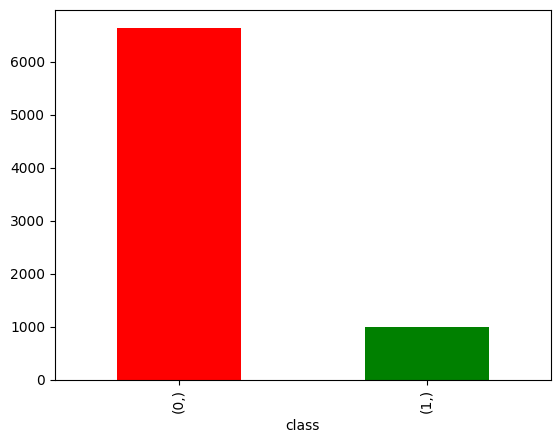

In [64]:
y.value_counts().plot.bar(color=['red','green'])

Como podemos ver en el gráfico de barras anterior, este conjunto de datos tiene dos clases: `Less Often` (Menos Frecuente) y `More Often` (Más Frecuente). Las dos etiquetas están desbalanceadas, siendo la mayoría de los alimentos que deberían elegirse con menor frecuencia para pacientes diabéticos.

## Construir un modelo SVM con parámetros predeterminados

Primero, dividamos el conjunto de datos en entrenamiento y prueba. El conjunto de datos de entrenamiento se usará para entrenar y ajustar los modelos, mientras que el conjunto de datos de prueba se usará para evaluar los modelos. Ten en cuenta que también puedes dividir un conjunto de validación a partir del conjunto de datos de entrenamiento solo para el ajuste del modelo.

In [65]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)

Bien, ahora que tenemos listos los conjuntos de datos de entrenamiento y prueba, comencemos ocn la tarea de entrenamiento del modelo.

Primero definimos un modelo `SVC` de `sklearn.svm` con todos los argumentos por defecto.

In [66]:
model = SVC()

Luego, entrena el modelo con el conjunto de datos de entrenamiento.

In [67]:
model.fit(X_train,y_train.values.ravel())

SVC()

Y hacemos las predicciones

In [68]:
preds = model.predict(X_test)

Aquí definimos un método de utilidad para evaluar el rendimiento del modelo.


In [69]:
def evaluate_metrics(yt,yp):
    result_pos= {}
    result_pos['accuracy'] = accuracy_score(yt,yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    result_pos['recall'] = recall
    result_pos['precision'] = precision
    result_pos['f1score'] = f_beta
    return result_pos



In [70]:
evaluate_metrics(y_test,preds)

{'accuracy': 0.9568062827225131,
 'recall': 0.7727272727272727,
 'precision': 0.8793103448275862,
 'f1score': 0.8225806451612904}

Como podemos ver en los resultados de la evaluación anteriores, el modelo SVM por defecto logra un rendimiento relativamente bueno en esta tarea de clasificación binaria. La precisión general es de aproximadamente `0.95` y el f1score es de alrededor de `0.82`.

Ahora, has construido fácilmente un modelo SVM con un rendimiento relativamente bueno. ¿Podemos lograr un mejor rendimiento en la clasificación personalizando el modelo?

## Entrenar SVM con diferentes parámetros de regularización y núcleos

El modelo `SVC` proporcionado por sklearn tiene dos argumentos importantes que se pueden ajustar: el parámetro de regularización `C` y el `kernel`.

El argumento `C` es un parámetro de regularización que controla el equilibrio entre lograr un error de entrenamiento bajo y mantener la frontera de decisión lo más simple posible.

* Para valores grandes de `C`, la optimización elegirá un hiperplano de margen más pequeño si ese hiperplano hace un mejor trabajo al clasificar correctamente todos los puntos de entrenamiento, lo que puede causar que el modelo sobreajuste.

* Por el contrario, un valor muy pequeño de `C` hará que el optimizador busque un hiperplano separador de mayor margen, incluso si ese hiperplano clasifica incorrectamente más puntos, pero podría tener una mejor generalización a datos no vistos.

El argumento `kernel` especifica el núcleo que se usará para transformar las características a espacios de mayor dimensión. Algunos núcleos no lineales comúnmente utilizados son:

* `rbf`: Función de Base Radial Gaussiana (RBF)
* `poly`: Núcleo Polinómico
* `sigmoid`: Núcleo Sigmoide

Primero intentemos con `C = 10` y `kernel = 'rbf'`.


In [71]:
model = SVC(C=10, kernel='rbf')
model.fit(X_train, y_train.values.ravel())
preds = model.predict(X_test)
evaluate_metrics(y_test, preds)

{'accuracy': 0.9679319371727748,
 'recall': 0.8333333333333334,
 'precision': 0.9116022099447514,
 'f1score': 0.8707124010554089}

Deberías observar que tenemos un mejor rendimiento en comparación con el modelo SVM predeterminado entrenado en el paso anterior. Ahora, te toca a ti probar diferentes parámetros por tu cuenta.

### Ejercicio de programación: Prueba diferentes valores de `C` y `kernels` para ver qué combinación produce modelos SVM con un mejor rendimiento de clasificación.

In [72]:
model = SVC(C=5, kernel='poly')
model.fit(X_train, y_train.values.ravel())
preds = model.predict(X_test)
evaluate_metrics(y_test,preds)

{'accuracy': 0.875,
 'recall': 0.045454545454545456,
 'precision': 0.8181818181818182,
 'f1score': 0.0861244019138756}

## Ajuste del parámetro de regularización C y Kernels mediante GridSearch

Probar exhaustivamente diferentes hiperparámetros manualmente es inviable. Por lo tanto, `sklearn` proporciona a los usuarios muchos métodos automáticos de ajuste de hiperparámetros. Uno popular es la validación cruzada de búsqueda en cuadrícula, `GridSearchCV`.

A continuación, probemos rápidamente `GridSearchCV` para encontrar la combinación optimizada de `C` y `kernel`:

Primero definimos algunos valores de parámetros candidatos que queremos buscar en un objeto `dict`, como la siguiente configuración:

In [73]:
param_grid = {
    'C' : [1,10,100],
    'kernel':['poly', 'rbf', 'sigmoid']
}

Luego, definimos el modelo SVM

In [74]:
model = SVC()

y creamos un método GridSearchCV para buscar en la cuadrícula `params_grid` y encontrar la combinación optimizada con el mejor puntaje f1. El proceso de búsqueda puede tardar varios minutos en completarse.

In [75]:
# Define un GridSearchCV para buscar los mejores parámetros
grid_search = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='f1',
                            cv=5, verbose=1)

# Busca los mejores parámetros con los datos de entrenamiento
grid_search.fit(X_train, y_train.values.ravel())
best_params = grid_search.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [76]:
best_params

{'C': 100, 'kernel': 'rbf'}

Bien, podemos ver que `C=100` y `kernel=rbf` parecen producir el f1score más alto. Probemos rápidamente esta combinación para ver el rendimiento del modelo.

In [77]:
model = SVC(C=100, kernel='rbf')
model.fit(X_train,y_train.values.ravel())
preds = model.predict(X_test)
evaluate_metrics(y_test,preds)

{'accuracy': 0.9698952879581152,
 'recall': 0.8787878787878788,
 'precision': 0.8877551020408163,
 'f1score': 0.883248730964467}

El mejor f1score ahora es `0.88` después de ajustar los hiperparámetros.

## Graficar el hiperplano y el margen de SVM

Bien, has aprendido cómo definir, entrenar, evaluar y afinar un modelo SVM con `sklearn`. Sin embargo, hasta ahora solo hemos obtenido métricas de evaluación simples y no son intuitivas para ayudarnos a comprender e interpretar un modelo SVM. Sería genial visualizar los hiperplanos y márgenes reales aprendidos en un modelo SVM.

Dado que es desafiante visualizar un hiperplano de más de 3 dimensiones, para ilustrar la idea, nos centraremos en un espacio de características de 2 dimensiones.

Primero simplificamos el conjunto de datos con solo dos características `Calories` y `Dietary Fiber`, e incluimos solo 1000 instancias:

In [78]:
simplified_food_df = food_df[['Calories', 'Dietary Fiber', 'class']]

In [79]:
X = simplified_food_df.iloc[:1000, :-1].values
y = simplified_food_df.iloc[:1000, -1:].values

y submuestreamos la clase mayoritaria Clase = 0 para equilibrar la distribución de clases, de modo que produzcamos una visualización más clara.


In [80]:
under_sampler = RandomUnderSampler(random_state=rs)
X_under, y_under = under_sampler.fit_resample(X,y)

In [81]:
print(f'Forma del conjunto de datos re-muestreado, X: {X_under.shape}, y:{y_under.shape}')

Forma del conjunto de datos re-muestreado, X: (62, 2), y:(62,)


Para mostrar mejor el hiperplano y los márgenes, normalizamos las características con un `MinMaxScaler`.

In [82]:
scaler = MinMaxScaler()
X_under = scaler.fit_transform(X_under)

Bien, primero entrenemos un modelo de SVM lineal con `kernel=linear` para que podamos obtener un hiperplano lineal y márgenes.

In [83]:
linear_svm = SVC(C=100, kernel='linear')
linear_svm.fit(X_under, y_under)

SVC(C=100, kernel='linear')

Aquí también proporcionamos un método de utilidad para trazar el límite de decisión (hiperplano), los vectores de soporte y los márgenes. Puedes escribir tu propio método de visualización si estás interesado.

In [98]:
def plot_decision_boundry(X, y, model):
    plt.figure(figsize=(16, 12))
    
    # Trazar los puntos de datos
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k')

    # Trazar la función de decisión
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Crear una malla para evaluar el modelo
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # Trazar la frontera de decisión y los márgenes
    ax.contour(
        XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
    )

    # Trazar los vectores de soporte
    ax.scatter(
        model.support_vectors_[:, 0],
        model.support_vectors_[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.show()

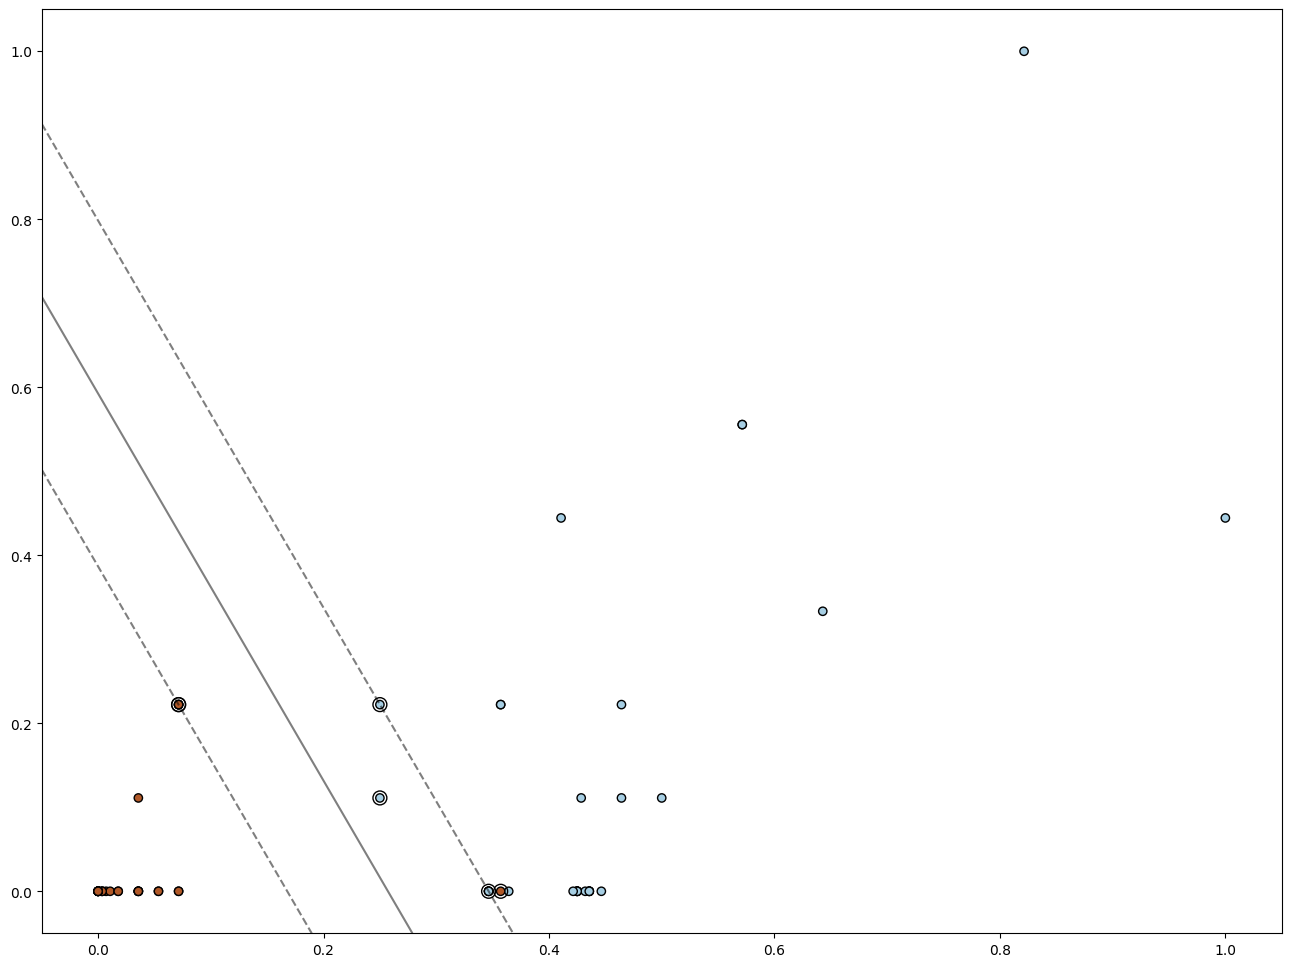

In [99]:
plot_decision_boundry(X_under, y_under,linear_svm)

Ahora, podemos ver un claro hiperplano lineal que separa las dos clases (puntos azules vs puntos naranjas). Los puntos destacados son los vectores de soporte que determinan el hiperplano.

Si queremos incluir núcleos no lineales, deberíamos obtener un límite de decisión no lineal en el espacio 2D (posiblemente lineal en un espacio de características más alto). Así que aquí utilizamos un núcleo rbf:

In [100]:
svm_rbf_kernel= SVC(C=100, kernel='rbf')
svm_rbf_kernel.fit(X_under,y_under)

SVC(C=100)

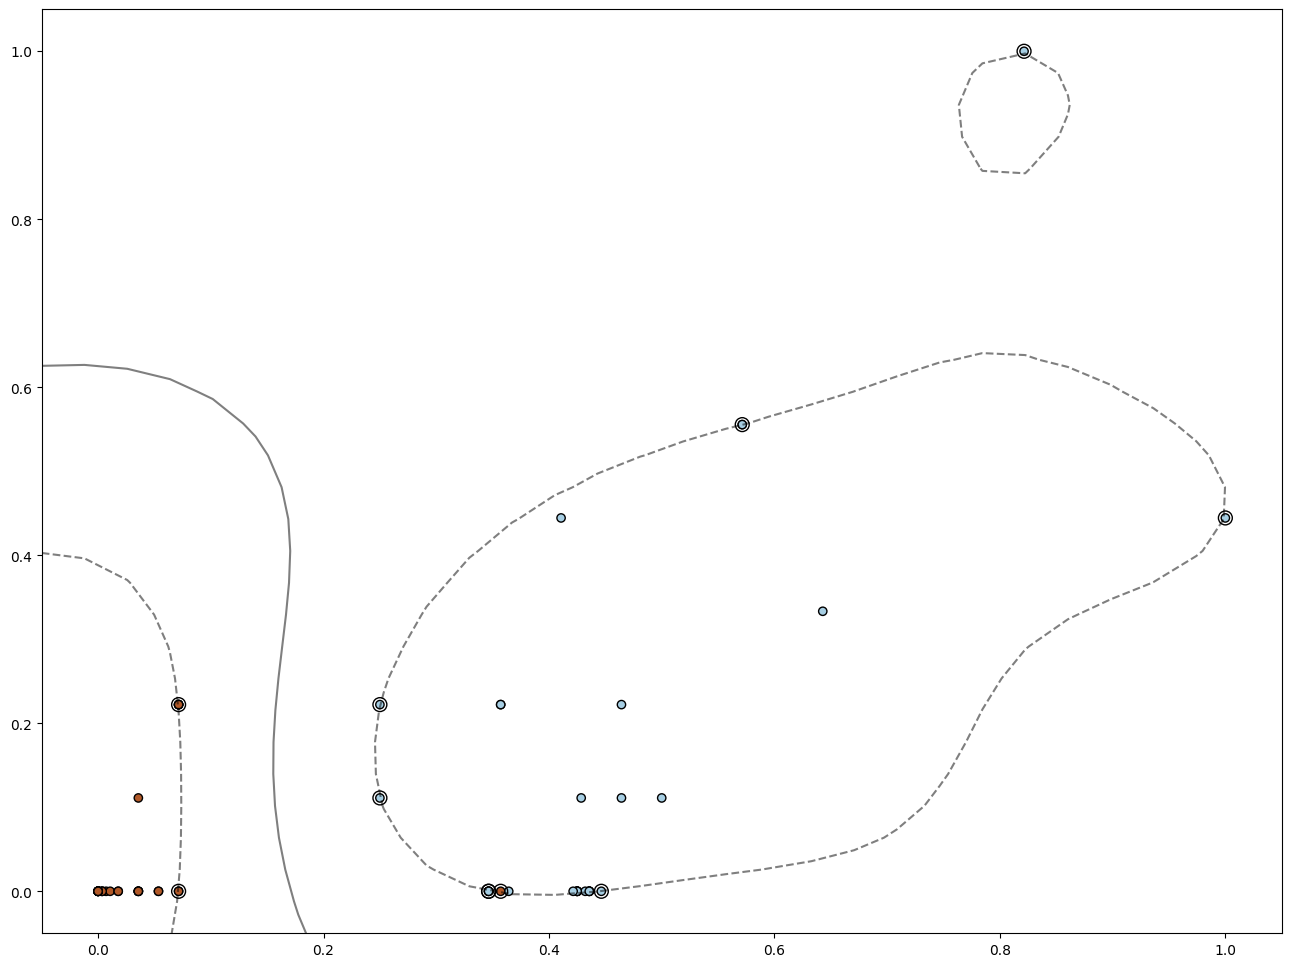

In [101]:
plot_decision_boundry(X_under, y_under, svm_rbf_kernel)

Ahora vemos un hiperplano y márgenes no lineales que separan las dos clases.


### Ejercicio de codificación: Prueba diferentes valores de `C` y `kernels` para ver cómo afectan los hiperplanos y los márgenes.

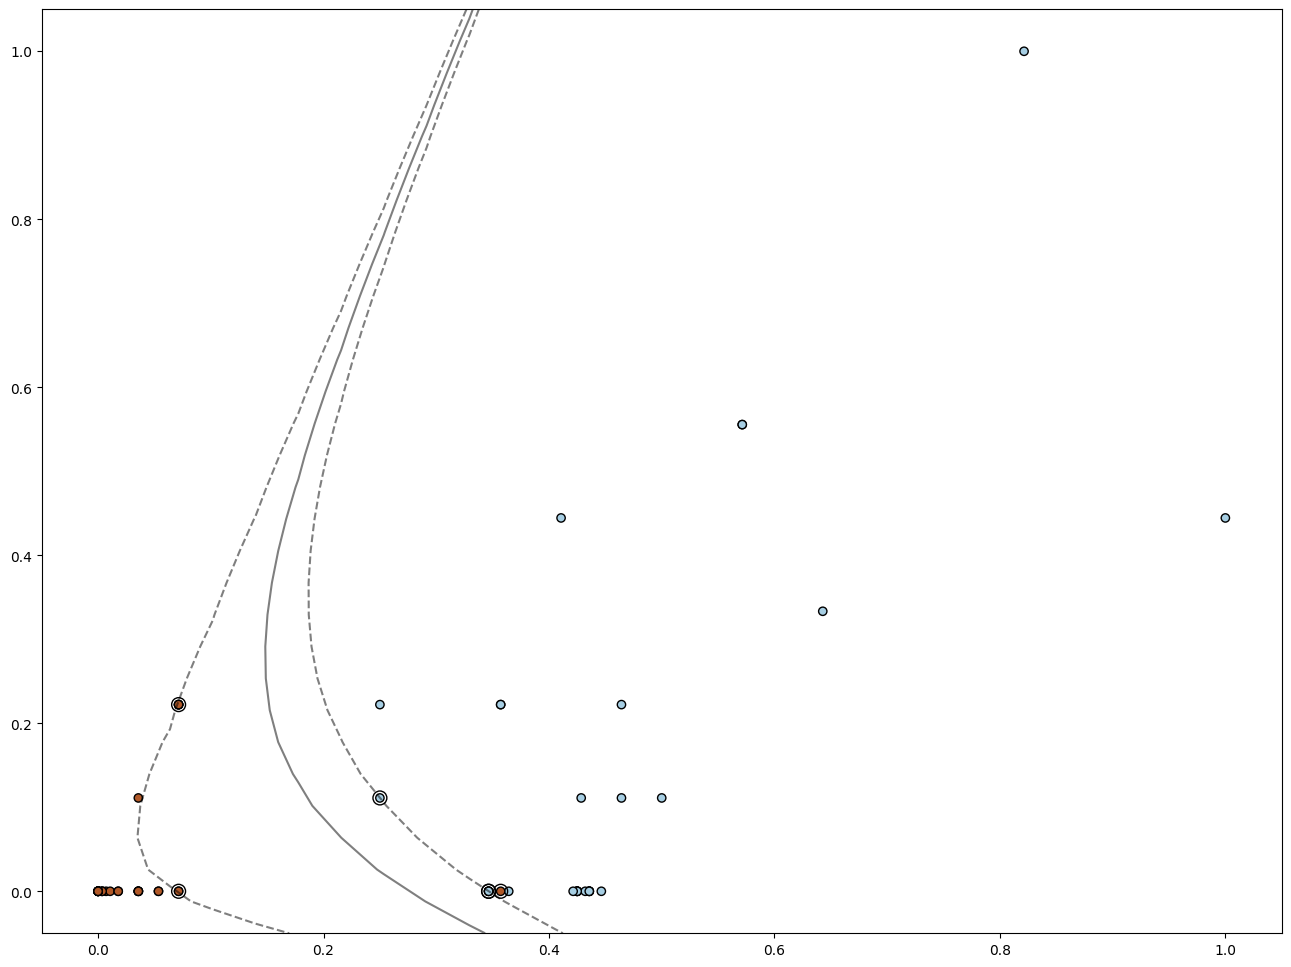

In [102]:
svm_rbf_kernel = SVC(C=100, kernel='poly')
svm_rbf_kernel.fit(X_under, y_under)
plot_decision_boundry(X_under, y_under, svm_rbf_kernel)

## Próximos Pasos

¡Genial! Ahora has aprendido y practicado el modelo SVM y lo has aplicado para resolver un problema de clasificación de alimentos en pacientes diabéticos. También aprendiste a visualizar los hiperplanos y márgenes generados por los modelos SVM.

A continuación, aprenderás sobre otros modelos de clasificación populares con diferentes estructuras, supuestos, funciones de costo y escenarios de aplicación.